# Лабораторная работа 2
## Полносвязная нейронная сеть
## 6408 Дробин Роман
Реализовать нейронную сеть, состоящую из двух полносвязных слоев и решающую задачу классификации на наборе данных из лабораторной работы 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from __future__ import print_function
from builtins import range
from builtins import object
from past.builtins import xrange
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from math import sqrt, ceil

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
_random_state = 322

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 1. Добавьте реализации методов класса TwoLayerNet . Проверьте вашу реализацию на модельных данных (Код приведен ниже).  

In [2]:
#scripts.classifiers.neural_net
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        first_layer_scores = X.dot(W1) + b1
        hidden_layer_scores = np.maximum(first_layer_scores, 0)
        scores = hidden_layer_scores.dot(W2) + b2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # If the targets are not given then jump out, we're done
        
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #Реализация softmax
        e_scores = np.exp(scores)
        e_scores_sum = e_scores.sum(axis=1).reshape(-1, 1)
        res_softmax = e_scores[:] / e_scores_sum

        loss_contributors = res_softmax[range(N), y]
        loss = -np.log(loss_contributors).sum() / N

        #Регуляризация
        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        d_scores = res_softmax
        d_scores[range(N), y] -= 1
        d_scores /= N

        # Вычисление градиентов второго слоя
        grads['W2'] = hidden_layer_scores.T.dot(d_scores)
        grads['b2'] = d_scores.sum(axis=0)

        # Вычисление градиентов первого слоя методом обратного распространения ошибки
        d_hidden = d_scores.dot(W2.T) #shape = (N, H)
        d_hidden_d_first_layer = np.zeros_like(first_layer_scores)
        d_hidden_d_first_layer[first_layer_scores > 0] = 1
        d_first_layer_scores = d_hidden * d_hidden_d_first_layer
        grads['W1'] = X.T.dot(d_first_layer_scores)
        grads['b1'] = d_first_layer_scores.sum(axis=0)

        # Регуляризация
        grads['W1'] += 2 * reg * W1
        grads['W2'] += 2 * reg * W2
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train // batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            batch_idxes = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idxes, :]
            y_batch = y[batch_idxes]
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # Пересчет весов в сторону антиградиента
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Проводим данные через НС
        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2
        # По принципу максимального правдоподобия выбор класса
        y_pred = np.argmax(scores, axis=1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred


In [3]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# 2. Прямой проход: вычисление выхода сети

Реализуйте первую часть  метода TwoLayerNet.loss, вычисляющую оценки классов для входных данных. 

Сравните ваш выход сети с эталонными значениями. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-7) .

In [4]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()


print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08



# 3. Прямой проход: вычисление loss

Реализуйте вторую часть метода, вычисляющую значение функции потерь. Сравните с эталоном. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-12) .

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# 4. Обратный проход

Реализуйте третью часть метода loss. Используйте численную реализацию расчета градиента для проверки вашей реализации обратного прохода.  Если прямой и обратный проходы реализованы верно, то ошибка будет < 1e-8 для каждой из переменных W1, W2, b1, и b2. 


In [6]:
#scripts.gradient_check
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [7]:
loss, grads = net.loss(X, y, reg=0.05)

for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# 5. Обучение нейронной сети на смоделированных данных

Реализуйте методы TwoLayerNet.train и TwoLayerNet.predict. Обучайте сеть до тех пор, пока значение loss не будет < 0.02.


Final training loss:  0.017149607938732048


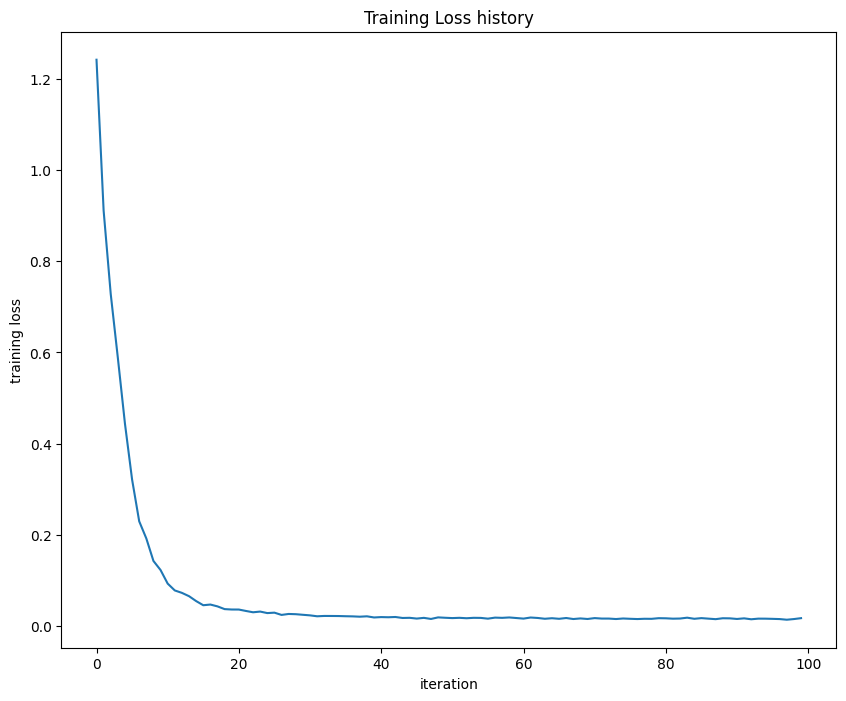

In [8]:
net = init_toy_model()
#Обучение модели
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])


plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# 6. Обучение нейронной сети на реальном наборе данных (CIFAR-10, MNIST)

Загрузите набор данных, соответствующий вашему варианту. 

Разделите данные на обучающую, тестовую и валидационную выборки.

Выполните предобработку данных, как в ЛР 1. 

Обучите нейронную сеть на ваших данных. 

При сдаче лабораторной работы объясните значения всех параметров метода train.

### Параметры train:

$X$: массив типа numpy размера $(N, D)$, содержащий обучающие данные.

$y$: массив типа numpy размера $(N,)$, содержащий метки обучения; $y[i] = c$ означает, что $X[i]$ имеет метку $c$, где $0 ≤ c < C$.

$X$\_$val$: массив типа numpy размера $(N$\_$val$, $D)$, содержащий данные для валидации.

$y$\_$val$: массив типа numpy размера $(N$\_$val,)$, содержащий метки валидации.

$learning$\_$rate$: Число, определяющее скорость обучения для оптимизации.

$learning$\_$rate$\_$decay$: Число, используемое для уменьшения скорости обучения после каждой эпохи.

$reg$: Число, определяющее степень регуляризации.

$num$\_$iters$: Количество шагов для оптимизации.

$batch$\_$size$: Число примеров обучения, используемых на каждом шаге.

$verbose$: значение типа boolean: если True, то выводит прогресс во время оптимизации.

In [9]:
#Подгружаем данные рукописных цифр
digits = load_digits()

X = digits.data #Признаки
y = digits.target #Метки классов
num_classes = len(set(y)) #Число классов

# Разделение данных на обучающую, тестовую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_random_state, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=_random_state, shuffle=True)

# Преобразование каждого изображения в одномерный массив
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Вывод размеров полученных выборок
print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры валидационной выборки:", X_val_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

Размеры обучающей выборки: (1077, 64)
Размеры валидационной выборки: (360, 64)
Размеры тестовой выборки: (360, 64)


In [10]:
input_size = 8 * 8
hidden_size = 32
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302591
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302588
iteration 300 / 1000: loss 2.302583
iteration 400 / 1000: loss 2.302592
iteration 500 / 1000: loss 2.302587
iteration 600 / 1000: loss 2.302581
iteration 700 / 1000: loss 2.302595
iteration 800 / 1000: loss 2.302587
iteration 900 / 1000: loss 2.302590
Validation accuracy:  0.05277777777777778


Используя параметры по умолчанию, вы можете получить accuracy, примерно равный 0.29. 

Проведите настройку гиперпараметров для увеличения accuracy. Поэкспериментируйте со значениями гиперпараметров, например, с количеством скрытых слоев, количеством эпох, скорости обучения и др. Ваша цель - максимально увеличить accuracy полносвязной сети на валидационном наборе. Различные эксперименты приветствуются. Например, вы можете использовать методы для сокращения размерности признакового пространства (например, PCA), добавить dropout слои и др. 

Для лучшей модели вычислите acсuracy на тестовом наборе. 

Для отладки процесса обучения часто помогают графики изменения loss и accuracy в процессе обучения. Ниже приведен код построения таких графиков. 

In [11]:
# Определение гиперпараметров для поиска

hidden_sizes = [150]
learning_rates = [0.095]
regularization_strengths = [1e-10]
learning_rate_decays = [1]
num_iterss = [2000]
batch_sizes = [150]
# Инициализация переменных для хранения лучших результатов
best_val_accuracy = -1
best_test_accuracy = -1
best_hyperparams = {}
stats = None

# Создание DataFrame для хранения результатов поиска
df = pd.DataFrame({'hs': [],
                   'lr': [],
                   'rs': [],
                   'lrd': [],
                   'ni': [],
                   'bs': [],
                   'acc': []})
# Перебор всех комбинаций гиперпараметров
ind = 0
for hs, lr, reg, lrd, ni, bs in itertools.product(hidden_sizes, learning_rates, regularization_strengths, learning_rate_decays, num_iterss, batch_sizes):
    # Инициализация и обучение модели с текущими гиперпараметрами
    net = TwoLayerNet(input_size, hs, num_classes)
    temp_stats = net.train(X_train, y_train, X_val, y_val,
                      num_iters=ni, batch_size=bs,
                      learning_rate=lr, learning_rate_decay=lrd,
                      reg=reg, verbose=False)
    # Оценка качества модели на валидационном и тестовом наборах данных
    val_accuracy = (net.predict(X_val) == y_val).mean()
    test_accuracy = (net.predict(X_test) == y_test).mean()
    params = {'hidden_size': hs, 'learning_rate': lr, 'reg': reg, 'learning_rate_decay': lrd, 'num_iters': ni, 'batch_size': bs}

    # Обновление лучших результатов, если текущая модель лучше
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy
        best_hyperparams = params
        stats = temp_stats

    # Добавление результатов в DataFrame
    row = pd.DataFrame({'hs': hs, 'lr': lr, 'rs': reg, 'lrd': lrd, 'ni': ni, 'bs': bs, 'acc': val_accuracy}, index=([ind]))
    df = pd.concat([df, row])
    ind += 1
# Вывод лучших результатов и результатов поиска
print("Лучшая точность на валидации:", best_val_accuracy)
print("Точность тестирования лучшей модели:", best_test_accuracy)
print("Лучшие гиперпараметры:", best_hyperparams)

print(df)

Лучшая точность на валидации: 0.9694444444444444
Точность тестирования лучшей модели: 0.9527777777777777
Лучшие гиперпараметры: {'hidden_size': 150, 'learning_rate': 0.095, 'reg': 1e-10, 'learning_rate_decay': 1, 'num_iters': 2000, 'batch_size': 150}
      hs     lr            rs  lrd      ni     bs       acc
0  150.0  0.095  1.000000e-10  1.0  2000.0  150.0  0.969444


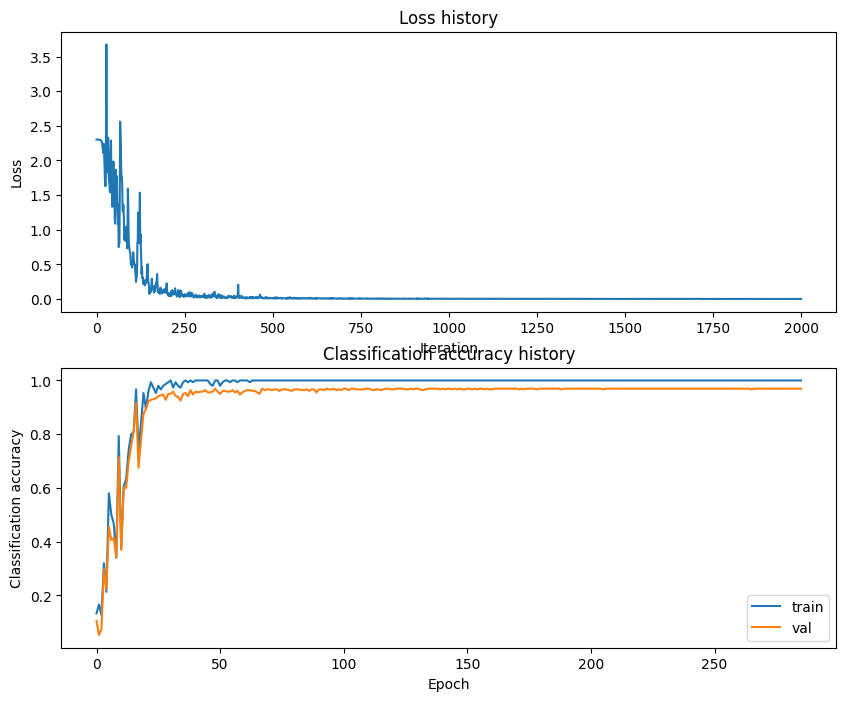

In [12]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [13]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

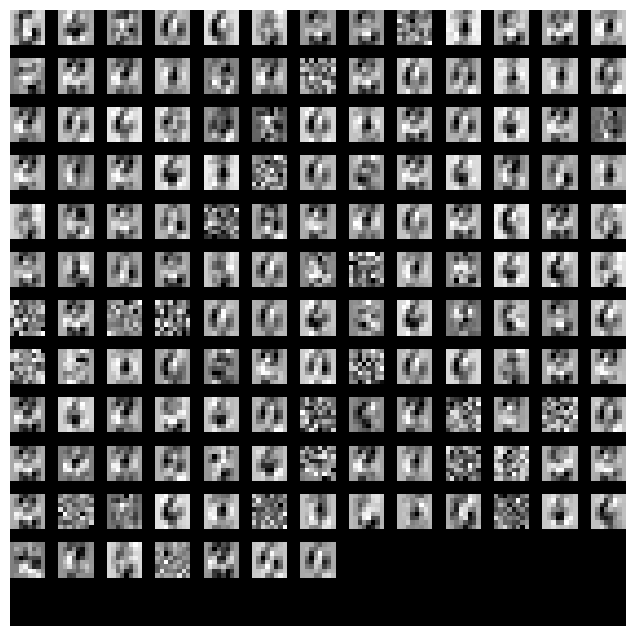

In [14]:
#from scripts.vis_utils import visualize_grid
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(8, 8, 1, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

Сделайте выводы по результатам работы. 

1. В результате была разработана и применена двухслойная полносвязная нейронная сеть.
2. По результатам тестирования нейронная сеть показала точность предсказания около $96\%$.
3. Эмпирическая зависимость между гиперпараметрами и точностью предсказания оказалось довольно сложной.
4. Для настройки параметров был использован полный перебор, что потребовало значительных временных ресурсов из-за огромного числа комбинаций.
5. Получено, что сохранение постоянной скорости обучения (learning_rate_decay = $1$) обеспечивает оптимальные результаты.
6. Были получены оптимальные гиперпараметры для нейронной сети:
   * hidden_size: $150$
   * learning_rate: $0.095$
   * reg: $1$$e$$-10$
   * learning_rate_decay: $1$
   * num_iters: $2000$
   * batch_size: $150$.